# Measles Vaccination Rates Project

This data contains the overall and measles, mumps, and rubella immunization rates for schools across the United States. Each row corresponds to one school and includes a number of variables including the latitude, longitude, name, and vaccination rates.

The dataset contains the following columns:

index: An identifier for each row.
    state: The state where the school is located.
year: The academic year for which the data was collected.
name: The name of the school.
type: The type of the school (e.g., public, private, charter).
city: The city where the school is located.
county: The county where the school is located.
district: The district where the school is located.
enroll: The number of students enrolled in the school.
mmr: The MMR vaccination rate at the school.
overall: The overall vaccination rate at the school.
xrel, xmed, xper: These columns seem to have many missing values. Without more information about what they represent, it's difficult to know how they could be used in the analysis.
lat, lng: The latitude and longitude of the school.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
data = pd.read_csv('measles.csv')

In [4]:
data.head()

,index,state,year,name,type,city,county,district,enroll,mmr,overall,xrel,xmed,xper,lat,lng
0,1,Arizona,2018-19,A J Mitchell Elementary,Public,Nogales,Santa Cruz,NaN,51.0,100.0,-1.0,NaN,NaN,NaN,31.347819,-110.938031
1,2,Arizona,2018-19,Academy Del Sol,Charter,Tucson,Pima,NaN,22.0,100.0,-1.0,NaN,NaN,NaN,32.221922,-110.896103
2,3,Arizona,2018-19,Academy Del Sol - Hope,Charter,Tucson,Pima,NaN,85.0,100.0,-1.0,NaN,NaN,NaN,32.130493,-111.117005
3,4,Arizona,2018-19,Academy Of Mathematics And Science South,Charter,Phoenix,Maricopa,NaN,60.0,100.0,-1.0,NaN,NaN,NaN,33.485447,-112.130633
4,5,Arizona,2018-19,Acclaim Academy,Charter,Phoenix,Maricopa,NaN,43.0,100.0,-1.0,NaN,2.33,2.33,33.495620,-112.224722


In [5]:
data['overall'].unique()

array([-1., 96., 99., ..., 10., 47.,  8.])

In [6]:
#count how many times each unique value of the overall column appears
data['overall'].value_counts()

-1.00      20177
 100.00     3172
 98.00      2112
 95.00      1798
 99.00       806
           ...  
 74.49         1
 70.42         1
 77.54         1
 70.69         1
 8.00          1
Name: overall, Length: 2691, dtype: int64

The 'overall' vaccination rate has been set to -1 in some rows. These are the rows for which the overall vaccination rate is not yet available, and which we're trying to predict.

Next, we will check how many rows have an 'overall' vaccination rate of '-1'. This will give us an idea of the amount of data we have for training our model (rows with a known overall vaccination rate) and for testing its predictions (rows with an 'overall' vaccination rate of '-1').

In [7]:
# Count the number of rows with 'overall' vaccination rate of -1
missing_overall = data[data['overall'] == -1].shape[0]

# Count the total number of rows
total_rows = data.shape[0]

missing_overall, total_rows, missing_overall / total_rows * 100

(20177, 46411, 43.474607312921506)

Out of a total of 46,411 schools, the overall vaccination rate is missing (represented as -1) for 20,177 schools. This means about 43.47% of the data is missing for the overall vaccination rate.

These missing rows can serve as the test data for our models, while the remaining rows can be used for training.

Now we will examine the relationships between the 'overall' vaccination rate and other variables in the dataset. This will help us identify which variables might be useful predictors for our model. For instance, we could look at the 'overall' vaccination rate versus the 'mmr' vaccination rate and 'lat' and 'lng' coordinates. We can also look at boxplots or bar plots of the 'overall' vaccination rate for different 'types' of schools.

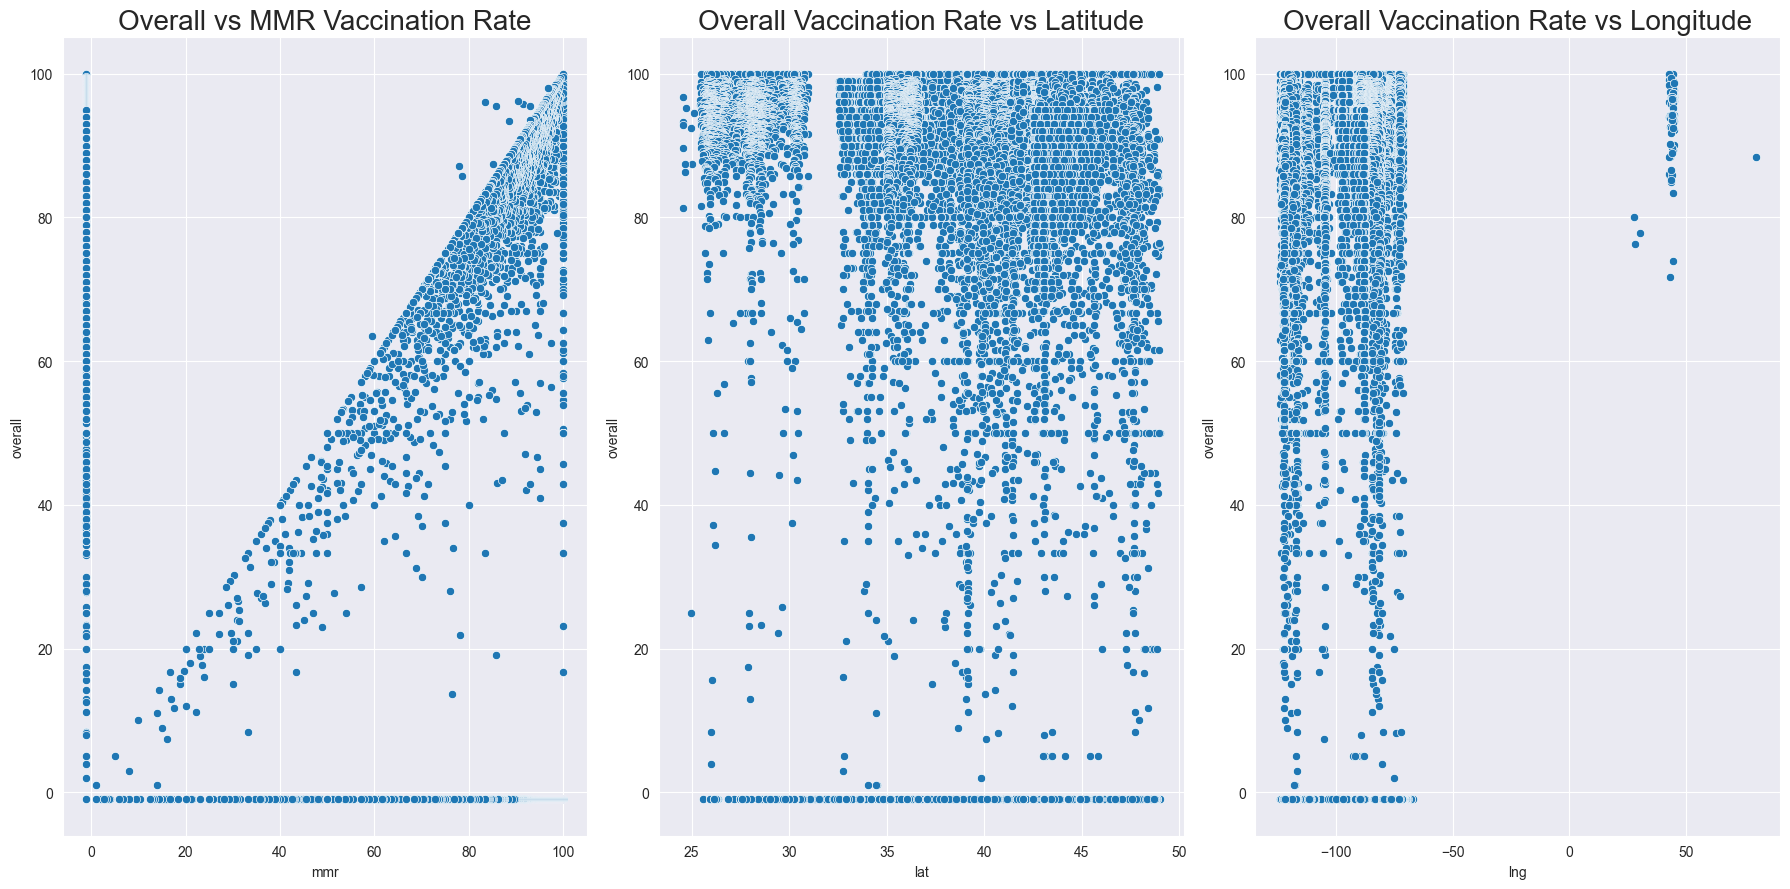

In [8]:


filtered_data = data[data['overall'] != -1]

subset_data = data


fig, axs = plt.subplots(1, 3, figsize=(18, 9))


plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 20


plt.rcParams['ytick.labelsize'] = 15

plt.rcParams['xtick.labelsize'] = 15


sns.scatterplot(data=subset_data, x='mmr', y='overall', ax=axs[0])
axs[0].set_title('Overall vs MMR Vaccination Rate')

sns.scatterplot(data=subset_data, x='lat', y='overall', ax=axs[1])
axs[1].set_title('Overall Vaccination Rate vs Latitude')

sns.scatterplot(data=subset_data, x='lng', y='overall', ax=axs[2])
axs[2].set_title('Overall Vaccination Rate vs Longitude')

plt.tight_layout()
plt.show()

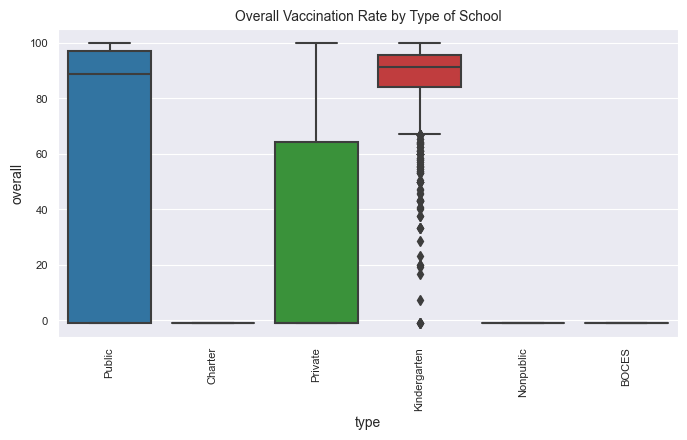

In [9]:
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 8

plt.rcParams['xtick.labelsize'] = 8



plt.figure(figsize=(8, 4))
sns.boxplot(data=subset_data, x='type', y='overall')
plt.title('Overall Vaccination Rate by Type of School')
plt.xticks(rotation=90)
plt.show()

Number of unique states, cities, and counties

In [10]:
filtered_data = data[data['overall'] != -1]


n_states = filtered_data['state'].nunique()
n_cities = filtered_data['city'].nunique()
n_counties = filtered_data['county'].nunique()

n_states, n_cities, n_counties

(17, 2557, 788)

In [11]:
 # Missing values

data.isnull().sum()

index           0
state           0
year         4681
name            0
type        27174
city        17339
county       5158
district    46411
enroll      12844
mmr             0
overall         0
xrel        46317
xmed        33439
xper        40000
lat          1552
lng          1552
dtype: int64

### Training

In [12]:

categorical_columns = ['type', 'state']
numerical_columns = ['mmr', 'lat', 'lng']

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='mean')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)
    ])

rf_model = RandomForestRegressor(n_estimators=100, random_state=0)
lr_model = LinearRegression()

training_data = filtered_data.copy()
prediction_data = data[data['overall'] == -1].copy()

X_train = training_data.drop(columns=['overall'])
y_train = training_data['overall']


X_predict = prediction_data.drop(columns=['overall'])

rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', rf_model)])

lr_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', lr_model)])


rf_pipeline.fit(X_train, y_train)
lr_pipeline.fit(X_train, y_train)

rf_train_preds = rf_pipeline.predict(X_train)
lr_train_preds = lr_pipeline.predict(X_train)

rf_rmse = mean_squared_error(y_train, rf_train_preds, squared=False)
rf_r2 = r2_score(y_train, rf_train_preds)


lr_rmse = mean_squared_error(y_train, lr_train_preds, squared=False)
lr_r2 = r2_score(y_train, lr_train_preds)

rf_rmse, rf_r2, lr_rmse, lr_r2

(3.3143292848829997, 0.9018279143808068, 7.132619972318334, 0.5453314864679981)

# Predictions

In [15]:

rf_predictions = rf_pipeline.predict(X_predict)
lr_predictions = lr_pipeline.predict(X_predict)


prediction_data['rf_predictions'] = rf_predictions
prediction_data['lr_predictions'] = lr_predictions

prediction_data.head()

,index,state,year,name,type,city,county,district,enroll,mmr,overall,xrel,xmed,xper,lat,lng,rf_predictions,lr_predictions
0,1,Arizona,2018-19,A J Mitchell Elementary,Public,Nogales,Santa Cruz,NaN,51.0,100.0,-1.0,NaN,NaN,NaN,31.347819,-110.938031,97.5109,165.893492
1,2,Arizona,2018-19,Academy Del Sol,Charter,Tucson,Pima,NaN,22.0,100.0,-1.0,NaN,NaN,NaN,32.221922,-110.896103,97.8837,169.317363
2,3,Arizona,2018-19,Academy Del Sol - Hope,Charter,Tucson,Pima,NaN,85.0,100.0,-1.0,NaN,NaN,NaN,32.130493,-111.117005,97.8837,169.323176
3,4,Arizona,2018-19,Academy Of Mathematics And Science South,Charter,Phoenix,Maricopa,NaN,60.0,100.0,-1.0,NaN,NaN,NaN,33.485447,-112.130633,97.9570,169.232791
4,5,Arizona,2018-19,Acclaim Academy,Charter,Phoenix,Maricopa,NaN,43.0,100.0,-1.0,NaN,2.33,2.33,33.495620,-112.224722,97.9870,169.232026


### Validation set

In [16]:
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(training_data, test_size=0.2, random_state=0)

X_train = train_data.drop(columns=['overall'])
y_train = train_data['overall']
X_val = val_data.drop(columns=['overall'])
y_val = val_data['overall']

rf_pipeline.fit(X_train, y_train)
lr_pipeline.fit(X_train, y_train)

rf_val_preds = rf_pipeline.predict(X_val)
lr_val_preds = lr_pipeline.predict(X_val)


rf_val_rmse = mean_squared_error(y_val, rf_val_preds, squared=False)
rf_val_r2 = r2_score(y_val, rf_val_preds)


lr_val_rmse = mean_squared_error(y_val, lr_val_preds, squared=False)
lr_val_r2 = r2_score(y_val, lr_val_preds)

rf_val_rmse, rf_val_r2, lr_val_rmse, lr_val_r2

(7.7041449805921935,
 0.48052493435329846,
 7.440431089912427,
 0.5154796633823411)